In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 10.7

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import CIFAR10,MNIST
from torch import Tensor

from dataclasses import dataclass

import random
import pandas as pd

import flwr as fl
from flwr.common import Metrics



In [ ]:

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


In [ ]:
BATCH_SIZE = 32
NUM_CLIENTS=5

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    trainset = MNIST("./dataset", train=True, download=True, transform=transform)
    testset = MNIST("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 5  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()


100%|██████████| 9912422/9912422 [00:00<00:00, 106441450.51it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18576245.03it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32458763.66it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6151284.72it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



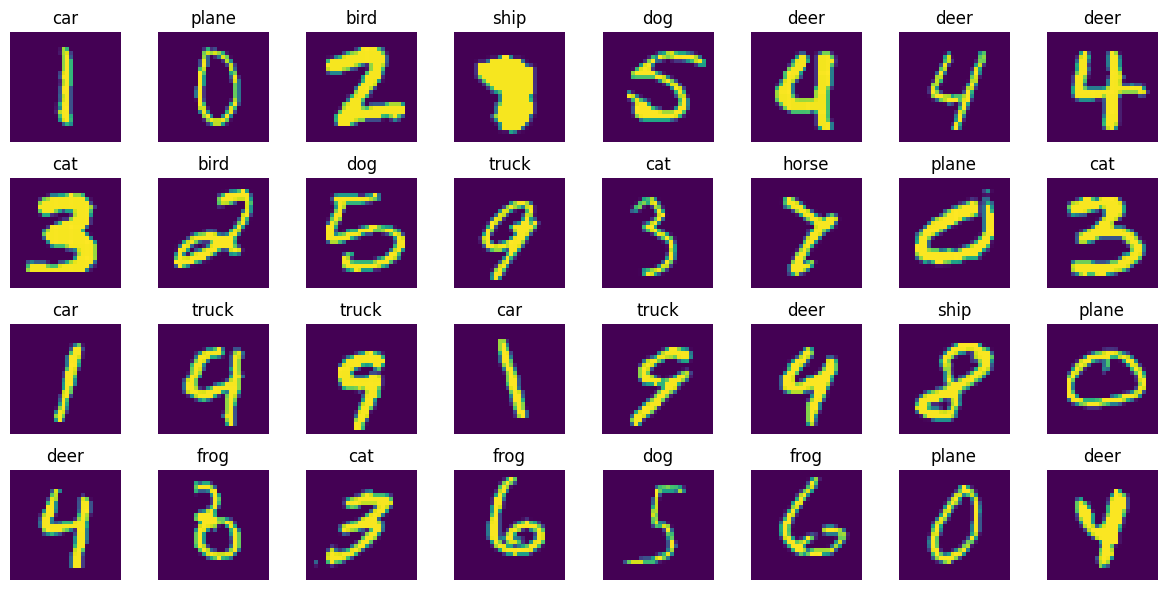

In [ ]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

Final test set performance:
	loss 0.0021364107358268483
	accuracy 0.9792


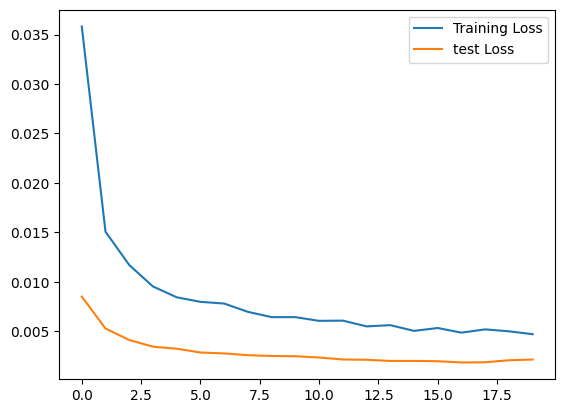

In [ ]:
from torchmetrics.functional import r2_score

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    each_node_train_loss = []
    each_node_valid_loss = []
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        lo = []
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        each_node_train_loss.append(epoch_loss.detach().numpy())
        #lo.append(epoch_loss)
        epoch_acc = correct / total
        # plt.plot(epoch_loss)
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


        # # Validation loop
        # net.eval()  # Set the model to evaluation mode
        # total_val_loss = 0.0

        # with torch.no_grad():
        #     for inputs, labels in valloaders[0]:
        #         inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        #         # Forward pass
        #         outputs = net(inputs)
        #         loss = criterion(outputs, labels)

        #         total_val_loss += loss.item()

        # avg_val_loss = total_val_loss / len(testloader.dataset)
        # each_node_valid_loss.append(avg_val_loss)




    return each_node_train_loss #, each_node_valid_loss


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss, r2loss = 0, 0, 0.0 , 0
    loss_list = []

    net.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs )
            loss += criterion(outputs, labels).item()
            # r2loss += r2_score(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total

    return loss, accuracy




trainloader = trainloaders[0]
valloader = valloaders[0]

net = Net().to(DEVICE)
test_loss = []
node_loss = []
node_valid_loss = []
for epoch in range(20):
    node_tain = train(net, trainloader, 1, verbose=False)
    node_loss.append(node_tain)
    # node_valid_loss.append(node_valid)
    loss, accuracy = test(net, testloader)
    test_loss.append(loss)

    # print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

train_loss = [tensor.item() for sublist in node_loss for tensor in sublist]

plt.plot(train_loss, label='Training Loss')
# plt.plot(node_valid_loss, label='Valid Loss')

plt.plot(test_loss, label='test Loss')
plt.legend()
plt.show()






In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



In [ ]:
from scipy.integrate import quad

""" Nash Equilibrium Values Calculation """
# write the function values for each of it
n= 5
# node_cost = 0.4
highest_value = 2

def integ(total_resource_cost, score):
    def NE(x):
        # return total_resource_cost * ((1 - np.exp(-score)) / (1 - np.exp(-highest_value)))**(n-3)
        return total_resource_cost * (score / highest_value)**(n-2)


    integral, _ = quad(NE, 0, highest_value)
    print("The Integral Value is = ", integral)

    return integral



""" NE END """


def normalize(data, data_min, data_max):
    d = (data - data_min) / (data_max - data_min)
    return d


""" Functions"""

class Euler():
  def __init__(self, X_init =1, Y_init=1 , step =10 ):
    self.x = np.zeros(step+1)
    self.y = np.zeros(step+1)

    self.x[0] = X_init
    self.y[0] = Y_init
    self.step = step


  def function(self,y,x):
    return y

  def approximate_value(self, x_required):
    h = (x_required - self.x[0]) / self.step

    for k in range(self.step):
      self.x[k+1] = self.x[k] + h
      self.y[k+1] = self.y[k] + h * self.function(self.y[k], self.x[k])
    return self.y[-1]


# Nash Equilibrium
def nash_equilibrium():
  # For each node, calculate q(θ) and p(θ)
  pass



def calculate_p(q):
  resource_value = sum(alpha * q)
  total_resource_cost = sum(resource_cost * q)
  profit = resource_value - total_resource_cost
  euler = Euler()
  p = euler.approximate_value(profit)

  # Have to modify accordingly

  resource_value = sum(alpha * q) + p
  total_resource_cost = sum(resource_cost * q)


  return round(p,2), total_resource_cost


def scoring_function(q,p):
  return np.sum(alpha*q) + p #np.min(alpha * q) +p

In [ ]:
from typing import Dict, Tuple

from flwr.common import Config, NDArrays, Scalar
from flwr.common.logger import log
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetPropertiesIns,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    Config
)


In [ ]:

P_MIN = 0.021334328158479184
P_MAX = 0.03875953108451435

DATA_MIN = int(1000)
DATA_MAX = int(5000)

BANDWIDTH_MIN = int(5)
BANDWIDTH_MAX = int(100)

RESOURCE = np.array([[random.randint(BANDWIDTH_MIN,BANDWIDTH_MAX), random.randint(DATA_MIN,DATA_MAX)]], dtype=float) # Bandwidth , Data

alpha = [0.5,0.5] # Alpha value for each feature,
resource_cost = [0.6 , 0.4] # cost for each resource
K= 2


In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

total_loss= []

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.total_loss=list()

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        self.total_loss.append(loss)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    def get_value(self):
      print("value is ", self.total_loss)


def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)


    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    cl = FlowerClient(net, trainloader, valloader)
    cl.get_value()

    return cl


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=3,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function

)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


NUM_CLIENTS = 5
num_rounds = 4
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-19 17:36:26,536 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
2023-09-19 17:36:29,467	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 17:36:33,516 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3919160524.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7838321051.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3919160524.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7838321051.0, 'CPU': 2.0}
INFO flwr 2023-09-19 17:36:33,525 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 17:36:33,528 | app.py:224 | Flower VCE: Resourc

(DefaultActor pid=2201) value is  []
(DefaultActor pid=2201) value is  []
(DefaultActor pid=2201) value is  [] [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(DefaultActor pid=2201) value is  [] [repeated 2x across cluster]


DEBUG flwr 2023-09-19 17:37:14,690 | server.py:236 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-19 17:37:14,709 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-19 17:37:14,715 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 5)


(DefaultActor pid=2201) value is  []
(DefaultActor pid=2200) value is  []


DEBUG flwr 2023-09-19 17:37:17,296 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-09-19 17:37:17,303 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:fit_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=2201) value is  [] [repeated 4x across cluster]
(DefaultActor pid=2201) value is  [] [repeated 2x across cluster]


DEBUG flwr 2023-09-19 17:37:45,961 | server.py:236 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-19 17:37:45,981 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 5)


(DefaultActor pid=2201) value is  []
(DefaultActor pid=2200) value is  []


DEBUG flwr 2023-09-19 17:37:48,501 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-19 17:37:48,507 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=2201) value is  [] [repeated 4x across cluster]
(DefaultActor pid=2201) value is  [] [repeated 2x across cluster]


DEBUG flwr 2023-09-19 17:38:15,360 | server.py:236 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-19 17:38:15,388 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 5)


(DefaultActor pid=2201) value is  []
(DefaultActor pid=2200) value is  []


DEBUG flwr 2023-09-19 17:38:19,686 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-19 17:38:19,693 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=2201) value is  [] [repeated 4x across cluster]
(DefaultActor pid=2201) value is  [] [repeated 2x across cluster]


DEBUG flwr 2023-09-19 17:38:45,286 | server.py:236 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-19 17:38:45,308 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 5)


(DefaultActor pid=2201) value is  []
(DefaultActor pid=2200) value is  []


DEBUG flwr 2023-09-19 17:38:48,955 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
INFO flwr 2023-09-19 17:38:48,964 | server.py:153 | FL finished in 125.44685991700004
INFO:flwr:FL finished in 125.44685991700004
INFO flwr 2023-09-19 17:38:48,968 | app.py:225 | app_fit: losses_distributed [(1, 0.014940980536242326), (2, 0.006084259019440247), (3, 0.004524895008912103), (4, 0.003815805617875109)]
INFO:flwr:app_fit: losses_distributed [(1, 0.014940980536242326), (2, 0.006084259019440247), (3, 0.004524895008912103), (4, 0.003815805617875109)]
INFO flwr 2023-09-19 17:38:48,973 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-19 17:38:48,977 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.89875), (2, 0.9447222222222222), (3, 0.9566666666666667), (4, 0.9622222222222222)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0

History (loss, distributed):
	round 1: 0.014940980536242326
	round 2: 0.006084259019440247
	round 3: 0.004524895008912103
	round 4: 0.003815805617875109
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.89875), (2, 0.9447222222222222), (3, 0.9566666666666667), (4, 0.9622222222222222)]}

In [ ]:

class FlowerClient(fl.client.NumPyClient):

    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.payment = list()
        self.node_train_loss = list()
        self.node_valid_loss = list()
        self.server_round =1
        self.RESOURCE = np.array([[self.cid,normalize(random.randint(BANDWIDTH_MIN,BANDWIDTH_MAX),BANDWIDTH_MIN,BANDWIDTH_MAX), normalize(random.randint(DATA_MIN,DATA_MAX),DATA_MIN,DATA_MAX)]] , dtype=float) # ID,Bandwidth , Data



    # return res. as dictionary here
    def get_properties(self, config: Config) -> Dict[str, Scalar]:
        retDict = {"client_id": self.cid,"bandwidth" : self.RESOURCE[0][1], "data" : self.RESOURCE[0][2]}
        return retDict



    # Return the current local model parameters
    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)



    # Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
    def fit(self, parameters, config):

        # Read values from config
        server_round = 1 #config["server_round"]
        local_epochs = 5 #config["local_epochs"]

        score = config["bid_score"]


        if "train" in config:
          print(str(self.cid) + " -> Please try train")
          self.payment.append(config["payment"])
          print("Payment Received",self.payment)


          # Use values provided by the config
          print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")

          set_parameters(self.net, parameters)
          node_loss = train(self.net, self.trainloader, epochs=local_epochs)

          values_train_loss = [arr.item() for arr in node_loss]

          print("Values of each node loss",values_train_loss)
          self.node_train_loss.append(values_train_loss)
          plt.plot(self.node_train_loss[0], label="Training Loss" )
          plt.title(f'Node {self.cid}')
          plt.xticks(np.arange(local_epochs))
          plt.savefig(f"MNIST_Node_{self.cid}.png")
          plt.show()


        else:

          print("skip training")

        results = dict()
        results["node_train_loss"] = self.node_train_loss[0]



        return get_parameters(self.net), len(self.trainloader), {}



    # : Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server
    def evaluate(self, parameters, config):

        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


    def get_node_losses(self):

      return self.node_train_loss




def fit_config(server_round: int):
    """Return training configuration dict for each round.
    """

    config = {

        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 2 else 2,  #
    }
    return config




def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    cl = FlowerClient(cid, net, trainloader, valloader)

    return cl



class MyStrategy(fl.server.strategy.FedAvg):
    #def initialize_parameters(self, client_manager):
        # Your implementation here

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        all_connected_clients_dict = client_manager.all()
        all_client_properties = list()

        for dict_key in all_connected_clients_dict.keys():
          config = {}
          ins = GetPropertiesIns(config=config)
          res = all_connected_clients_dict[dict_key].get_properties(ins, 100)
          res = (res.properties)
          all_client_properties.append(res)

        # preprocess to calculte bid Score  and p_value

        client_id = [[client_id["client_id"]] for client_id in  all_client_properties]
        bandwidth_data = [[d["bandwidth"],d["data"]] for d in all_client_properties]
        bandwidth_data = np.asarray(bandwidth_data)
        print("bandwidth_data",bandwidth_data)


        """
        # NE to calculate Payment Allocation

        """
        scoring_board = list()
        p_client = list()
        payment = list()
        for q in bandwidth_data:

          p_value, total_resource_cost = calculate_p(q)
          p_client.append(p_value)

          client_bid_socre = scoring_function(q,p_value)

          """ NE """
          node_payment = client_bid_socre  + integ(total_resource_cost,client_bid_socre)

          """ NE """

          scoring_board.append(client_bid_socre)
          payment.append(node_payment*100)
          print(client_bid_socre, node_payment)


        score_dic = [{"client_id":id , "bid_score" : score , "p_value" : p , "payment" : node_payment } for id, score , p ,node_payment  in zip(client_id,scoring_board, p_client,payment)]
        print("Client Scoring Board",score_dic)

        top_k = sorted(score_dic, key=lambda x:x["bid_score"], reverse =True)
        top_k = top_k[:K]
        print("The Client with Higher Score", top_k)


        # Selecting the Top k for Training
        client_to_train = list()
        top_client_ids = [[client_id["client_id"]] for client_id in  top_k]


        # chosing client for training
        for client in top_k:


          client_id = client["client_id"]
          payment = client["payment"]
          score = client["bid_score"]

          proxy = all_connected_clients_dict[str(client_id[0][0])]
          # print("proxy", proxy)

          # Create a dict to send instruction
          dic = {"train" : True,"bid_score" :score ,"payment" : payment}

          fitIn = FitIns(parameters=parameters, config=dic)
          client_to_train.append([proxy, fitIn])

        print("Returing to CLient to Train")
        return client_to_train



    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
          # Convert `Parameters` to `List[np.ndarray]`
          aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

          # Save aggregated_ndarrays
          print(f"Saving round {server_round} aggregated_ndarrays...")
          np.savez(f"round-{server_round}-weights.npz", *aggregated_ndarrays)

        print("Server round -> " + str(server_round))
        # for result in results:
        #   print("Here is the result", str(result.FitRes))

        return aggregated_parameters, aggregated_metrics


    #def configure_evaluate(self, server_round, parameters, client_manager):
        # Your implementation here

    # def aggregate_evaluate(self, server_round, results, failures):
        # Your implementation here

    #def evaluate(self, parameters):
        # Your implementation here
NUM_CLIENTS = 5
NUM_ROUND = 4



def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}



strategy = MyStrategy(
    fraction_fit=1,
    fraction_evaluate=1,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function

    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(Net())),
    # evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)




client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}


fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-09-19 17:38:49,096 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
2023-09-19 17:38:53,441	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 17:38:56,008 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 7822725120.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3911362560.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7822725120.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3911362560.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-09-19 17:38:56,019 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 17:38:56,025 | app.py:224 | Flower VCE: Resourc

bandwidth_data [[0.88421053 0.52375   ]
 [0.95789474 0.65875   ]
 [0.37894737 0.865     ]
 [0.2        0.7575    ]
 [0.8        0.50925   ]]
The Integral Value is =  0.20451441264288714
1.0339802631578947 1.2384946758007818
The Integral Value is =  0.3173205713125238
1.1483223684210526 1.4656429397335764
The Integral Value is =  0.13991820718277445
0.9919736842105263 1.1318918913933007
The Integral Value is =  0.06465762348486327
0.84875 0.9134076234848633
The Integral Value is =  0.1681836222227852
0.9946250000000001 1.1628086222227854
Client Scoring Board [{'client_id': ['0'], 'bid_score': 1.0339802631578947, 'p_value': 0.33, 'payment': 123.84946758007817}, {'client_id': ['1'], 'bid_score': 1.1483223684210526, 'p_value': 0.34, 'payment': 146.56429397335765}, {'client_id': ['2'], 'bid_score': 0.9919736842105263, 'p_value': 0.37, 'payment': 113.18918913933007}, {'client_id': ['3'], 'bid_score': 0.84875, 'p_value': 0.37, 'payment': 91.34076234848632}, {'client_id': ['4'], 'bid_score': 0

DEBUG flwr 2023-09-19 17:40:02,706 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-19 17:40:02,720 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-09-19 17:40:02,732 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)


Saving round 1 aggregated_ndarrays...
Server round -> 1
(DefaultActor pid=3030) [Client 1] evaluate, config: {}
(DefaultActor pid=3030) Values of each node loss [0.03366309031844139, 0.013856478966772556, 0.0109803332015872, 0.009494184516370296, 0.008254997432231903]
(DefaultActor pid=3030) Figure(640x480)


DEBUG flwr 2023-09-19 17:40:06,886 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-09-19 17:40:07,781 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.11578947 0.39375   ]
 [0.86315789 0.19725   ]
 [0.30526316 0.957     ]
 [0.65263158 0.65225   ]
 [0.37894737 0.802     ]]
The Integral Value is =  0.013184174941161432
0.6147697368421052 0.6279539117832666
The Integral Value is =  0.09169261192873865
0.8502039473684211 0.9418965592971598
The Integral Value is =  0.1419703369377752
1.0011315789473683 1.1431019158851434
The Integral Value is =  0.1643170773585359
1.0024407894736842 1.16675786683222
The Integral Value is =  0.12142564872520892
0.9604736842105264 1.0818993329357354
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.6147697368421052, 'p_value': 0.36, 'payment': 62.79539117832667}, {'client_id': ['1'], 'bid_score': 0.8502039473684211, 'p_value': 0.32, 'payment': 94.18965592971598}, {'client_id': ['2'], 'bid_score': 1.0011315789473683, 'p_value': 0.37, 'payment': 114.31019158851434}, {'client_id': ['3'], 'bid_score': 1.0024407894736842, 'p_value': 0.35, 'payment': 116.675786683222}, {'client_id': ['4

DEBUG flwr 2023-09-19 17:41:01,068 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-19 17:41:01,086 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)


Saving round 2 aggregated_ndarrays...
Server round -> 2
(DefaultActor pid=3032) Figure(640x480)
(DefaultActor pid=3030) [Client 2] evaluate, config: {}
(DefaultActor pid=3030) Values of each node loss [0.008941959589719772, 0.008115505799651146, 0.007301590405404568, 0.007281925063580275, 0.006467527709901333]
(DefaultActor pid=3030) Figure(640x480)
(DefaultActor pid=3032) [Client 3] evaluate, config: {} [repeated 4x across cluster]


DEBUG flwr 2023-09-19 17:41:08,175 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-19 17:41:09,074 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.56842105 0.26425   ]
 [0.88421053 0.78375   ]
 [0.46315789 0.29875   ]
 [0.77894737 0.7215    ]
 [0.98947368 0.7665    ]]
The Integral Value is =  0.048322637359385946
0.7563355263157895 0.8046581636751754
The Integral Value is =  0.3414116868027798
1.1739802631578948 1.5153919499606747
The Integral Value is =  0.03722928466991671
0.720953947368421 0.7581832320383377
The Integral Value is =  0.2517019799286682
1.1002236842105262 1.3519256641391943
The Integral Value is =  0.40667495943617205
1.217986842105263 1.6246618015414351
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.7563355263157895, 'p_value': 0.34, 'payment': 80.46581636751753}, {'client_id': ['1'], 'bid_score': 1.1739802631578948, 'p_value': 0.34, 'payment': 151.53919499606747}, {'client_id': ['2'], 'bid_score': 0.720953947368421, 'p_value': 0.34, 'payment': 75.81832320383377}, {'client_id': ['3'], 'bid_score': 1.1002236842105262, 'p_value': 0.35, 'payment': 135.19256641391942}, {'client_id': ['

DEBUG flwr 2023-09-19 17:42:01,989 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-19 17:42:02,002 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=3032) Figure(640x480)
Saving round 3 aggregated_ndarrays...
Server round -> 3
(DefaultActor pid=3030) [Client 2] evaluate, config: {}


DEBUG flwr 2023-09-19 17:42:06,583 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-19 17:42:07,481 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 5)


bandwidth_data [[0.8        0.20175   ]
 [0.45263158 0.8255    ]
 [0.44210526 0.5805    ]
 [0.78947368 0.50825   ]
 [0.37894737 0.724     ]]
The Integral Value is =  0.08040399726283991
0.830875 0.9112789972628399
The Integral Value is =  0.15002348945070249
0.9990657894736842 1.1490892789243867
The Integral Value is =  0.0794636031447774
0.8613026315789474 0.9407662347237248
The Integral Value is =  0.16365354026368295
0.9888618421052633 1.1525153823689462
The Integral Value is =  0.09786703404826869
0.9114736842105263 1.009340718258795
Client Scoring Board [{'client_id': ['0'], 'bid_score': 0.830875, 'p_value': 0.33, 'payment': 91.12789972628399}, {'client_id': ['1'], 'bid_score': 0.9990657894736842, 'p_value': 0.36, 'payment': 114.90892789243867}, {'client_id': ['2'], 'bid_score': 0.8613026315789474, 'p_value': 0.35, 'payment': 94.07662347237248}, {'client_id': ['3'], 'bid_score': 0.9888618421052633, 'p_value': 0.34, 'payment': 115.25153823689462}, {'client_id': ['4'], 'bid_score': 

DEBUG flwr 2023-09-19 17:43:01,279 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-19 17:43:01,299 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=3032) Figure(640x480)
Saving round 4 aggregated_ndarrays...
Server round -> 4
(DefaultActor pid=3032) [Client 0] evaluate, config: {}
(DefaultActor pid=3030) Values of each node loss [0.005181603599339724, 0.005489424802362919, 0.005293570924550295, 0.004901929758489132, 0.0048557305708527565]
(DefaultActor pid=3030) Figure(640x480)


DEBUG flwr 2023-09-19 17:43:07,510 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 5 results and 0 failures
INFO flwr 2023-09-19 17:43:07,518 | server.py:153 | FL finished in 251.43657563600004
INFO:flwr:FL finished in 251.43657563600004
INFO flwr 2023-09-19 17:43:07,521 | app.py:225 | app_fit: losses_distributed [(1, 0.00384960175336649), (2, 0.002317216453879761), (3, 0.0020251231784228973), (4, 0.0018974193558921493)]
INFO:flwr:app_fit: losses_distributed [(1, 0.00384960175336649), (2, 0.002317216453879761), (3, 0.0020251231784228973), (4, 0.0018974193558921493)]
INFO flwr 2023-09-19 17:43:07,523 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-19 17:43:07,525 | app.py:227 | app_fit: metrics_distributed {'accuracy': [(1, 0.9638333333333333), (2, 0.9766666666666667), (3, 0.9805), (4, 0.9806666666666667)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 

History (loss, distributed):
	round 1: 0.00384960175336649
	round 2: 0.002317216453879761
	round 3: 0.0020251231784228973
	round 4: 0.0018974193558921493
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9638333333333333), (2, 0.9766666666666667), (3, 0.9805), (4, 0.9806666666666667)]}